<span style="font-size:24px; font-weight:bold; color:black;">Step 1: Data Understanding & Preparation</span>

In [59]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler  
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [69]:
# Load the dataset
df = pd.read_csv('online_shoppers_intention.csv')

# Explore missing values
print("Missing values in each column:\n", df.isnull().sum())

# Describe the dataset
print("Dataset Overview:\n", df.describe())
# Drop missing values
df = df.dropna()


Missing values in each column:
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64
Dataset Overview:
        Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         2.315166                80.818611       0.503569   
std          3.321784               176.779107       1.270156   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000   

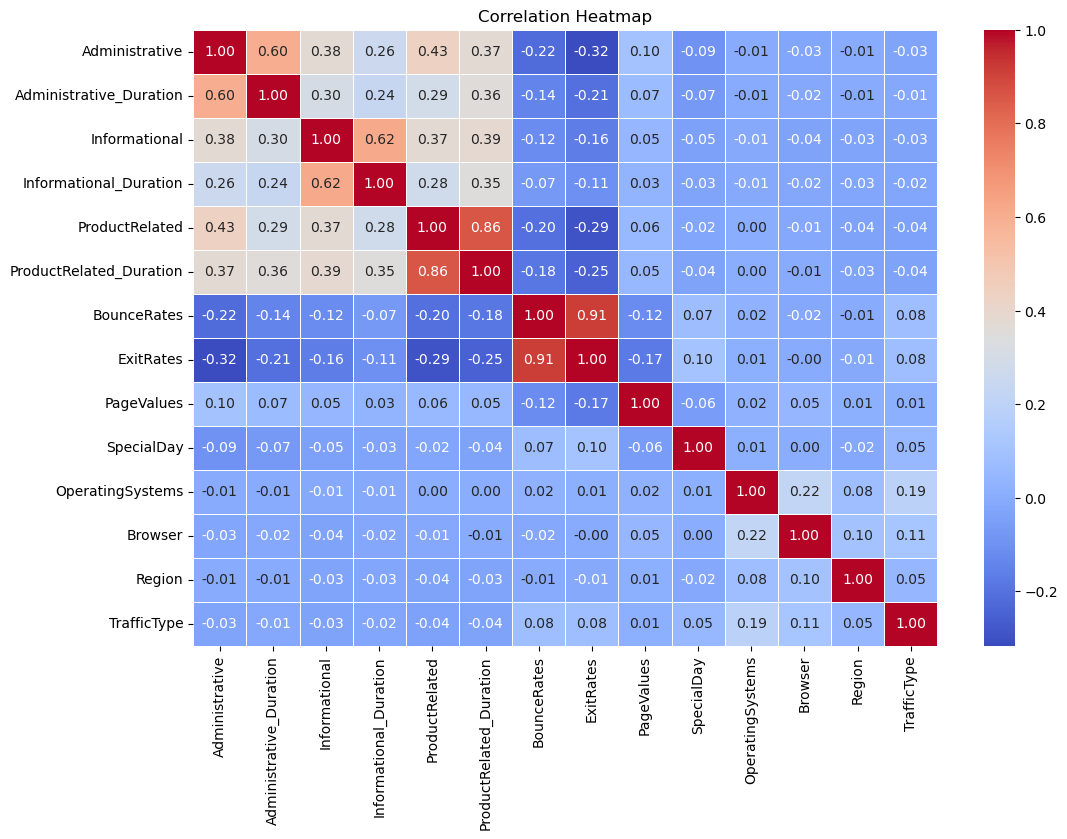

In [71]:
# Separate features and target
X = df.drop(columns=['Revenue'])
y = df['Revenue']
# Select only numeric columns for correlation calculation
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.savefig('class_correlation.png')
plt.show()

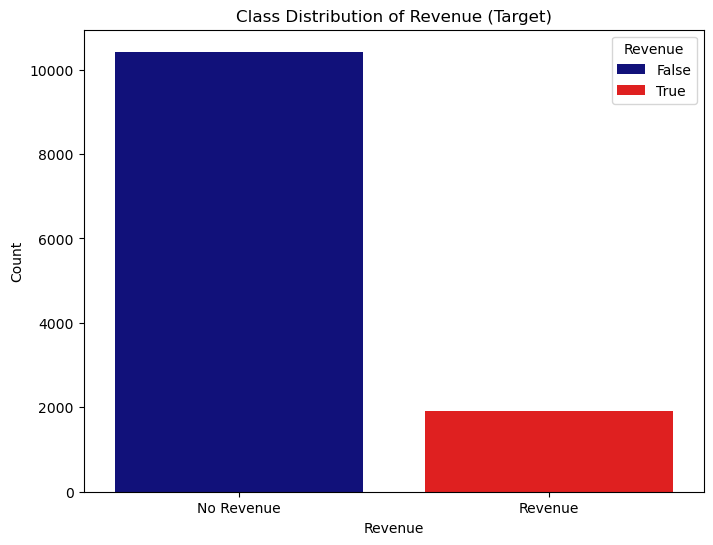

In [73]:
# plot distribution of Target
plt.figure(figsize=(8, 6))
sns.countplot(x=y, hue=y, palette=['darkblue', 'red'], dodge=False) 
plt.title('Class Distribution of Revenue (Target)')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Revenue', 'Revenue'])
plt.grid(False)
plt.savefig('revenue_class_distribution.png')
plt.show()

<span style="font-size:24px; font-weight:bold; color:black;">Step 2: Data Preparation</span>

In [33]:
# Define preprocessing for categorical variables
categorical_columns = ['Month', 'VisitorType', 'Weekend']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['Month', 'VisitorType']),
        ('binary', 'passthrough', ['Weekend']),
    ],
    remainder='passthrough'  # Keep numerical columns as it is
)

# Preprocess features
X_preprocessed = preprocessor.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, stratify=y)

print("Preprocessing complete. Data is ready for training.")


Preprocessing complete. Data is ready for training.


<span style="font-size:24px; font-weight:bold; color:black;">Step 3: Model Training</span>

In [35]:
# Train Logistic Regression with scaling
logistic_pipeline = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=500, random_state=42, solver='lbfgs') 
)
logistic_pipeline.fit(X_train, y_train)

# Train other models
random_forest_model = RandomForestClassifier(random_state=42)
gradient_boosting_model = GradientBoostingClassifier(random_state=42)

random_forest_model.fit(X_train, y_train)
gradient_boosting_model.fit(X_train, y_train)

print("Model training complete.")


Model training complete.


<span style="font-size:24px; font-weight:bold; color:black;">Step 4: Model Testing and Evaluation</span>

In [37]:
# Collect metrics for all models
metrics = []

# Logistic Regression Metrics
y_pred_logistic = logistic_pipeline.predict(X_test)
metrics.append([
    "Logistic Regression",
    accuracy_score(y_test, y_pred_logistic),
    precision_score(y_test, y_pred_logistic),
    recall_score(y_test, y_pred_logistic),
    f1_score(y_test, y_pred_logistic),
    roc_auc_score(y_test, y_pred_logistic)
])

# Random Forest Metrics
y_pred_rf = random_forest_model.predict(X_test)
metrics.append([
    "Random Forest",
    accuracy_score(y_test, y_pred_rf),
    precision_score(y_test, y_pred_rf),
    recall_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_rf),
    roc_auc_score(y_test, y_pred_rf)
])

# Gradient Boosting Metrics
y_pred_gb = gradient_boosting_model.predict(X_test)
metrics.append([
    "Gradient Boosting",
    accuracy_score(y_test, y_pred_gb),
    precision_score(y_test, y_pred_gb),
    recall_score(y_test, y_pred_gb),
    f1_score(y_test, y_pred_gb),
    roc_auc_score(y_test, y_pred_gb)
])

# Create a DataFrame for better presentation
results_df = pd.DataFrame(metrics, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])

print(results_df)


                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.881184   0.743169  0.356021  0.481416  0.666734
1        Random Forest  0.901460   0.749104  0.547120  0.632375  0.756766
2    Gradient Boosting  0.901460   0.724919  0.586387  0.648336  0.772800


<span style="font-size:24px; font-weight:bold; color:black;">Step 5: Hyperparameter Tuning and Evaluation</span>

In [39]:
# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'logisticregression__C': [0.01, 0.1, 1, 10],
        'logisticregression__solver': ['lbfgs', 'liblinear'],
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
    }
}

# Initialize models and pipelines
models = {
    'Logistic Regression': make_pipeline(
        StandardScaler(with_mean=False),
        LogisticRegression(max_iter=500, random_state=42)
    ),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Perform hyperparameter tuning and collect the best models
best_estimators = {}
for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}\n")

# Evaluate all models on the test set
all_metrics = []
for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    all_metrics.append([
        model_name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred)
    ])

# Create a DataFrame for comparison
comparison_df = pd.DataFrame(all_metrics, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])

# Display the results
print("\nModel Performance After Hyperparameter Tuning:")
print(comparison_df)


Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for Logistic Regression: {'logisticregression__C': 1, 'logisticregression__solver': 'lbfgs'}

Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Tuning hyperparameters for Gradient Boosting...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


Model Performance After Hyperparameter Tuning:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.881184   0.743169  0.356021  0.481416  0.666734
1        Random Forest  0.899432   0.732639  0.552356  0.629851  0.757704
2    Gradient Boosting  0.901460   0.724919  0.58638

<span style="font-size:24px; font-weight:bold; color:black;">Step 6: Evaluation of prediction</span>

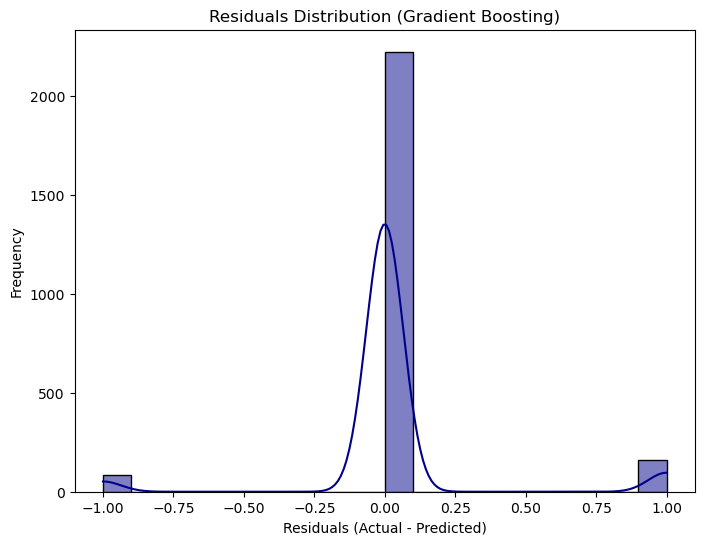

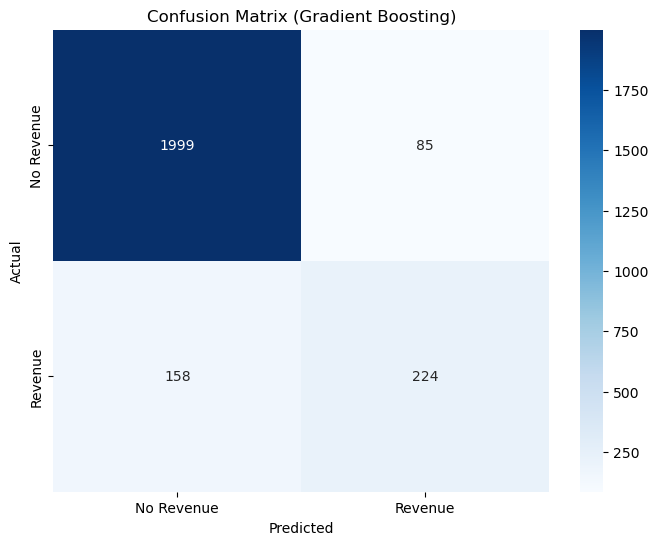

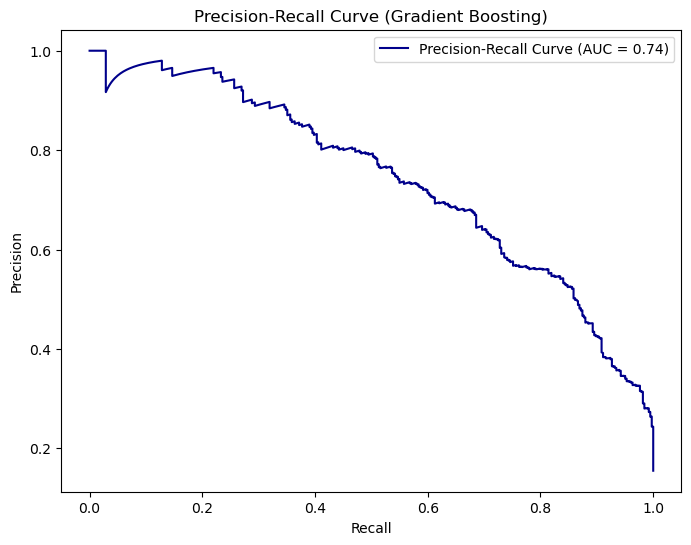

Percentage of Correctly Predicted No-Revenue Outcomes: 95.92%
Percentage of Correctly Predicted Revenue-Making Outcomes: 58.64%


In [75]:
# Use the best Gradient Boosting model from hyperparameter tuning
best_gb = best_estimators['Gradient Boosting']

# Predict outcomes and probabilities using the best Gradient Boosting model
y_pred_gb = best_gb.predict(X_test)
y_proba_gb = best_gb.predict_proba(X_test)[:, 1]  # Probability for Revenue=True

#Residuals Analysis
# Convert boolean arrays to integers for subtraction
residuals = np.array(y_test, dtype=int) - np.array(y_pred_gb, dtype=int)

# Plot Residuals Histogram
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=20, kde=True, color="Darkblue")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (Gradient Boosting)")
plt.savefig("residuals_distribution.png", dpi=300)
plt.show()

# plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Revenue", "Revenue"], yticklabels=["No Revenue", "Revenue"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Gradient Boosting)")
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

# plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_gb)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="Darkblue", label=f"Precision-Recall Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Gradient Boosting)")
plt.legend(loc="upper right")
plt.savefig("precision_recall_curve.png", dpi=300)
plt.show()

# Calculate the percentage of correctly predicted outcomes for both classes
# True Negative Rate for Revenue=False
non_revenue_outcome_accuracy = (cm[0, 0] / cm[0].sum()) * 100  # TN / (TN + FP)
# Recall for Revenue=True
revenue_outcome_accuracy = (cm[1, 1] / cm[1].sum()) * 100  # TP / (TP + FN)

print(f"Percentage of Correctly Predicted No-Revenue Outcomes: {non_revenue_outcome_accuracy:.2f}%")
print(f"Percentage of Correctly Predicted Revenue-Making Outcomes: {revenue_outcome_accuracy:.2f}%")


<span style="font-size:24px; font-weight:bold; color:black;">Step 7: Improvement : SMOT</span>

In [43]:
!pip install imbalanced-learn

Classification Report after SMOTE Oversampling:
               precision    recall  f1-score   support

       False       0.94      0.94      0.94      2084
        True       0.66      0.66      0.66       382

    accuracy                           0.89      2466
   macro avg       0.80      0.80      0.80      2466
weighted avg       0.89      0.89      0.89      2466



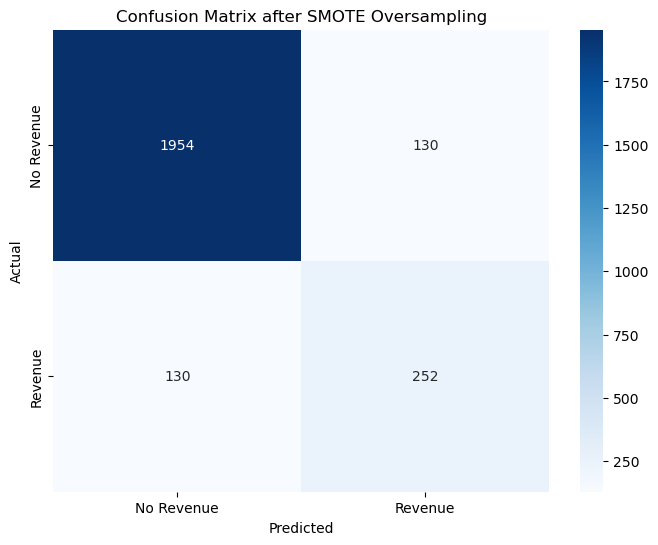

Percentage of Correctly Predicted No-Revenue Outcomes: 93.76%
Percentage of Correctly Predicted Revenue-Making Outcomes: 65.97%


In [47]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the Gradient Boosting model on the resampled dataset
balanced_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=42
)
balanced_gb.fit(X_resampled, y_resampled)

# Evaluate the model on the test set
y_pred_balanced = balanced_gb.predict(X_test)

# Print classification report
print("Classification Report after SMOTE Oversampling:\n", classification_report(y_test, y_pred_balanced))

cm_balanced = confusion_matrix(y_test, y_pred_balanced)
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_balanced, annot=True, fmt="d", cmap="Blues", xticklabels=["No Revenue", "Revenue"], yticklabels=["No Revenue", "Revenue"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix after SMOTE Oversampling")
plt.show()

# Calculate the percentage of correctly predicted outcomes for both classes
non_revenue_outcome_accuracy = (cm_balanced[0, 0] / cm_balanced[0].sum()) * 100
revenue_outcome_accuracy = (cm_balanced[1, 1] / cm_balanced[1].sum()) * 100
print(f"Percentage of Correctly Predicted No-Revenue Outcomes: {non_revenue_outcome_accuracy:.2f}%")
print(f"Percentage of Correctly Predicted Revenue-Making Outcomes: {revenue_outcome_accuracy:.2f}%")


<span style="font-size:24px; font-weight:bold; color:black;">7.1 : Improvement : Undersampling The Majority (No Revenue)</span>

Classification Report after Undersampling:
               precision    recall  f1-score   support

       False       0.97      0.86      0.91      2084
        True       0.52      0.83      0.64       382

    accuracy                           0.85      2466
   macro avg       0.74      0.84      0.77      2466
weighted avg       0.90      0.85      0.87      2466



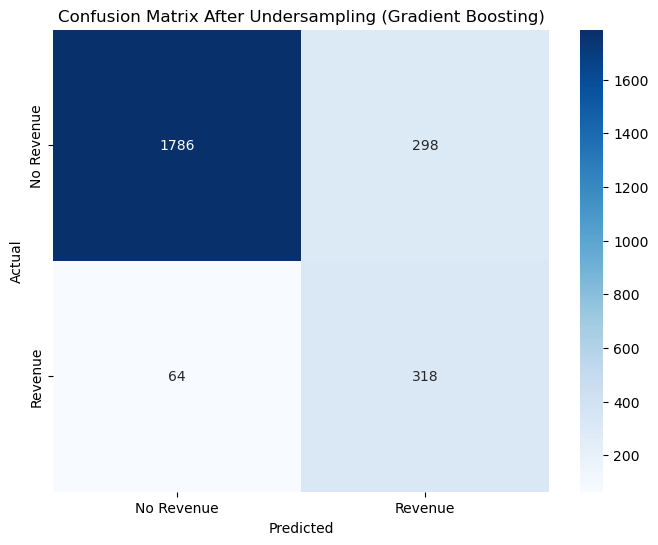

Percentage of Correctly Predicted No-Revenue Outcomes: 85.70%
Percentage of Correctly Predicted Revenue-Making Outcomes: 83.25%


In [49]:
# Apply undersampling to the majority class
undersampler = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

# Train the Gradient Boosting model on the undersampled dataset
undersampled_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=42
)
undersampled_gb.fit(X_undersampled, y_undersampled)

# Evaluate the model on the test set
y_pred_undersampled = undersampled_gb.predict(X_test)

# Print classification report
print("Classification Report after Undersampling:\n", classification_report(y_test, y_pred_undersampled))

# Compute confusion matrix
cm_undersampled = confusion_matrix(y_test, y_pred_undersampled)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_undersampled, annot=True, fmt='d', cmap='Blues', xticklabels=["No Revenue", "Revenue"], yticklabels=["No Revenue", "Revenue"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Undersampling (Gradient Boosting)')
plt.show()

# Calculate the percentage of correctly predicted outcomes for both classes
non_revenue_outcome_accuracy = (cm_undersampled[0, 0] / cm_undersampled[0].sum()) * 100  # TN / (TN + FP)
revenue_outcome_accuracy = (cm_undersampled[1, 1] / cm_undersampled[1].sum()) * 100  # TP / (TP + FN)

print(f"Percentage of Correctly Predicted No-Revenue Outcomes: {non_revenue_outcome_accuracy:.2f}%")
print(f"Percentage of Correctly Predicted Revenue-Making Outcomes: {revenue_outcome_accuracy:.2f}%")


<span style="font-size:24px; font-weight:bold; color:black;">7.2 : Improvement : SMOTEENN</span>

Classification Report after Hybrid SMOTE + ENN:
               precision    recall  f1-score   support

       False       0.96      0.90      0.93      2084
        True       0.58      0.78      0.66       382

    accuracy                           0.88      2466
   macro avg       0.77      0.84      0.79      2466
weighted avg       0.90      0.88      0.88      2466



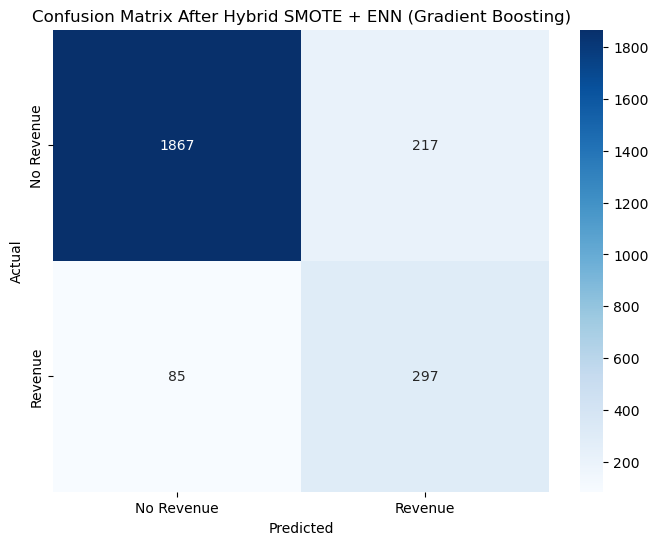

Percentage of Correctly Predicted No-Revenue Outcomes: 89.59%
Percentage of Correctly Predicted Revenue-Making Outcomes: 77.75%


In [51]:
# Apply SMOTEENN to the training data
smoteenn = SMOTEENN(random_state=42)
X_hybrid, y_hybrid = smoteenn.fit_resample(X_train, y_train)

# Train the Gradient Boosting model on the hybrid-balanced dataset
hybrid_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=42
)
hybrid_gb.fit(X_hybrid, y_hybrid)

# Evaluate the model on the test set
y_pred_hybrid = hybrid_gb.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report after Hybrid SMOTE + ENN:\n", classification_report(y_test, y_pred_hybrid))

# Compute the confusion matrix
cm_hybrid = confusion_matrix(y_test, y_pred_hybrid)


# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', xticklabels=["No Revenue", "Revenue"], yticklabels=["No Revenue", "Revenue"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Hybrid SMOTE + ENN (Gradient Boosting)')
plt.show()

# Calculate the percentage of correctly predicted outcomes for both classes
non_revenue_outcome_accuracy = (cm_hybrid[0, 0] / cm_hybrid[0].sum()) * 100  # TN / (TN + FP)
revenue_outcome_accuracy = (cm_hybrid[1, 1] / cm_hybrid[1].sum()) * 100  # TP / (TP + FN)

print(f"Percentage of Correctly Predicted No-Revenue Outcomes: {non_revenue_outcome_accuracy:.2f}%")
print(f"Percentage of Correctly Predicted Revenue-Making Outcomes: {revenue_outcome_accuracy:.2f}%")


<span style="font-size:24px; font-weight:bold; color:black;">Step 8: Comparison of Result</span>

In [53]:
# Data for the comparison table
data = {
    "Method": ["SMOTE", "Undersampling", "SMOTE + ENN"],
    "No-Revenue Precision": [0.94, 0.97, 0.96],
    "No-Revenue Recall": [0.94, 0.86, 0.90],
    "Revenue Precision": [0.66, 0.52, 0.58],
    "Revenue Recall": [0.66, 0.83, 0.78],
    "Accuracy": ["89%", "85%", "88%"],
    "No-Revenue (%)": [93.76, 85.70, 89.59],
    "Revenue (%)": [65.97, 83.25, 77.75]
}

# Create a DataFrame
comparison_df = pd.DataFrame(data).set_index("Method").T

comparison_df

Method                SMOTE Undersampling SMOTE + ENN
No-Revenue Precision   0.94          0.97        0.96
No-Revenue Recall      0.94          0.86         0.9
Revenue Precision      0.66          0.52        0.58
Revenue Recall         0.66          0.83        0.78
Accuracy                89%           85%         88%
No-Revenue (%)        93.76          85.7       89.59
Revenue (%)           65.97         83.25       77.75

<span style="font-size:24px; font-weight:bold; color:black;">Step 9: Final Evaluation of Prediction</span>

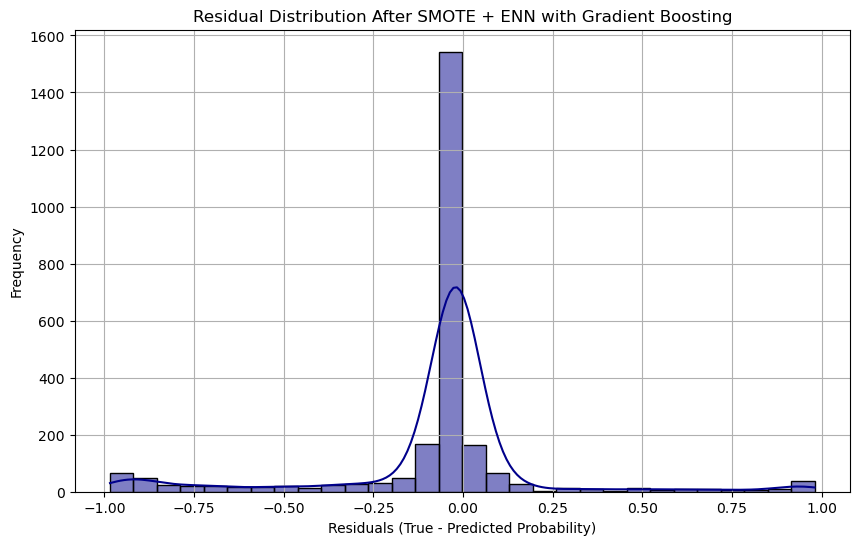

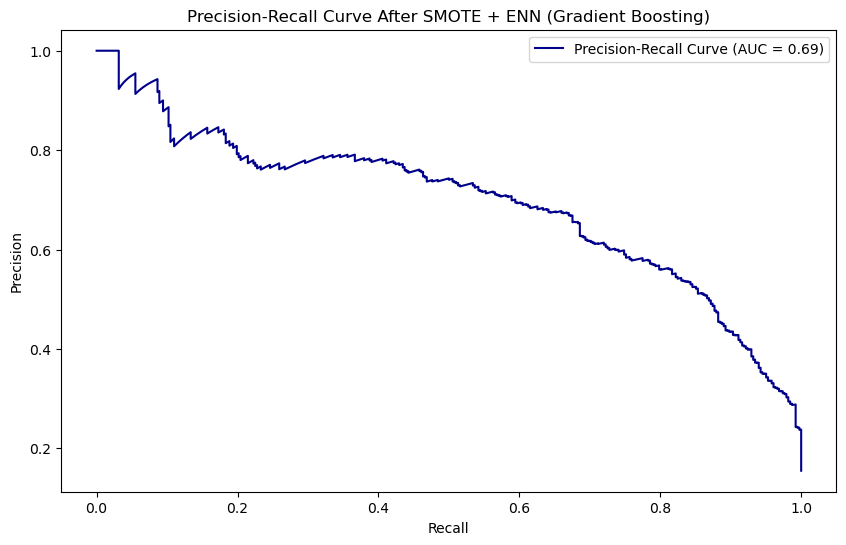

In [77]:
# Get predicted probabilities for the positive class (1)
y_pred_prob = hybrid_gb.predict_proba(X_test)[:, 1]

# Calculate residuals (difference between true and predicted labels)
residuals = y_test - y_pred_prob

# Plot the residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='Darkblue', bins=30)
plt.title('Residual Distribution After SMOTE + ENN with Gradient Boosting')
plt.xlabel('Residuals (True - Predicted Probability)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('smoteeen_residual_distribution_plot.png')  
plt.show()

# plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color="Darkblue", label=f"Precision-Recall Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve After SMOTE + ENN (Gradient Boosting)")
plt.legend(loc="upper right")
plt.savefig('precision_recall_curve_smoteenn.png') 
plt.show()